In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.optimize import minimize


def open_excel_data(file_path):
    """Function to read excel file with multiple sheets"""
    xls = pd.ExcelFile(file_path)
    sheet_names = xls.sheet_names
    data_dict = {sheet: pd.read_excel(xls, sheet) for sheet in sheet_names}
    return data_dict

In [34]:
# Rate Constants

# Load data from the excelsheet
data = open_excel_data("DataSet_CellPolarity.xlsx")["MAIN data"]
data.columns = [
    "Unnamed: 0", "EmbryoID", "Line", "Date",
    "Cytosol concentration (a.u.)", 
    "Membrane concentration (total) (a.u.)", 
    "Membrane concentration (ventral) (a.u.)", 
    "Membrane concentration (dorsal) (a.u.)", 
    "State", "Genotype"
]

def analyze_genotype(genotype, state):
    # Filter the data based on genotype (WT, L155R, and C49S and there state (polarized/non-polarized)
    filtered_data = data[(data['State'] == state) & (data['Genotype'] == genotype)]
    
    # Calculate average VINP concentrations in the cytosol and membrane
    C_avg = filtered_data['Cytosol concentration (a.u.)'].mean()
    M_avg = filtered_data['Membrane concentration (dorsal) (a.u.)'].mean()
    # Print the average VINP concentrations in the cytosol and membrane for each genotype and state
    print(f"\nGenotype: {genotype} | State: {state}")
    print(f"Average Cytosol Concentration: {C_avg:.4f}")
    print(f"Average Membrane-Dorsal Concentration: {M_avg:.4f}")

    # Define the rate contant and the steady-state equations
    def objective(params):
        K_on, K_off, K_coop, K_diss = params
        eq1 = -K_on * C_avg + K_off * M_avg - 2 * K_coop * (C_avg ** 2) * M_avg + 2 * K_diss * (M_avg ** 3)
        eq2 = K_on * C_avg - K_off * M_avg + 2 * K_coop * (C_avg ** 2) * M_avg - 2 * K_diss * (M_avg ** 3)
        return eq1**2 + eq2**2  # Squared errors to minimize

    # Initial guesses for the rate constant 
    initial_guess = [1e-3, 1e-3, 1e-3, 1e-3]

    # Optimize the results using the Nelder-Mead method
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    K_on_est, K_off_est, K_coop_est, K_diss_est = result.x

    # Print the rate constants for each genotype and state
    print(f"Estimated K_on: {K_on_est:.6f}")
    print(f"Estimated K_off: {K_off_est:.6f}")
    print(f"Estimated K_coop: {K_coop_est:.6f}")
    print(f"Estimated K_diss: {K_diss_est:.6f}")

    return {
        "Genotype": genotype,
        "State": state,
        "K_on": K_on_est,
        "K_off": K_off_est,
        "K_coop": K_coop_est,
        "K_diss": K_diss_est
    }

# print results for all three genotypes in both states
results = []
for genotype in ["WT", "L155R","C49S"]:
    for state in ["polarized", "non-polarized"]:
        results.append(analyze_genotype(genotype, state))

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
print("\nFinal Results:\n", results_df)



Genotype: WT | State: polarized
Average Cytosol Concentration: 1350.0671
Average Membrane-Dorsal Concentration: 25044.6675
Estimated K_on: 0.001177
Estimated K_off: 0.001056
Estimated K_coop: 0.001447
Estimated K_diss: 0.000004

Genotype: WT | State: non-polarized
Average Cytosol Concentration: 1031.4577
Average Membrane-Dorsal Concentration: 11463.9924
Estimated K_on: 0.001175
Estimated K_off: 0.001056
Estimated K_coop: 0.001446
Estimated K_diss: 0.000012

Genotype: L155R | State: polarized
Average Cytosol Concentration: 2410.8862
Average Membrane-Dorsal Concentration: 13044.1204
Estimated K_on: 0.001151
Estimated K_off: 0.001064
Estimated K_coop: 0.001454
Estimated K_diss: 0.000050

Genotype: L155R | State: non-polarized
Average Cytosol Concentration: 1636.9962
Average Membrane-Dorsal Concentration: 8386.4974
Estimated K_on: 0.001143
Estimated K_off: 0.001080
Estimated K_coop: 0.001447
Estimated K_diss: 0.000055

Genotype: C49S | State: polarized
Average Cytosol Concentration: 2616.

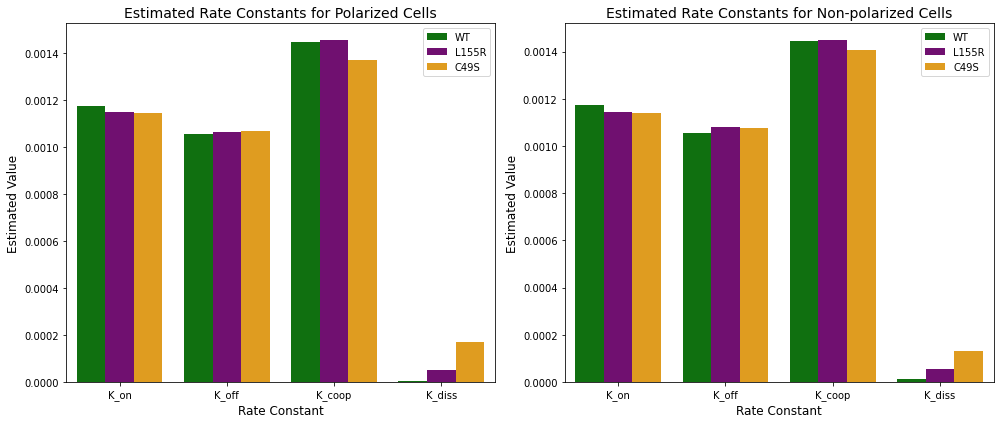

In [35]:
#Plot the estimated rate constants

# Reshape the obtained data for plotting
df_melted = results_df.melt(id_vars=["Genotype", "State"], var_name="Rate Constant", value_name="Value")
df_melted["Group"] = df_melted["Genotype"] + " - " + df_melted["State"]

#plot data
#establish the color per genotype
custom_palette = {
    "WT": "green",      # Green
    "L155R": "purple",  # Purple
    "C49S": "orange"    # Orange
}

# Create a figure with two subplots (polarized and non-polarized)
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# plot the rate contants
for i, state in enumerate(["polarized", "non-polarized"]):
    df_subset = df_melted[df_melted["State"] == state]
    sns.barplot(data=df_subset, x="Rate Constant", y="Value", hue="Genotype", palette=custom_palette, ax=axes[i])
    axes[i].set_xlabel("Rate Constant", fontsize=12)
    axes[i].set_ylabel("Estimated Value", fontsize=12)
    axes[i].set_title(f"Estimated Rate Constants for {state.capitalize()} Cells", fontsize=14)
    axes[i].legend(loc='upper right')  # Place legend at the top-right inside the graph

plt.tight_layout()
plt.show()

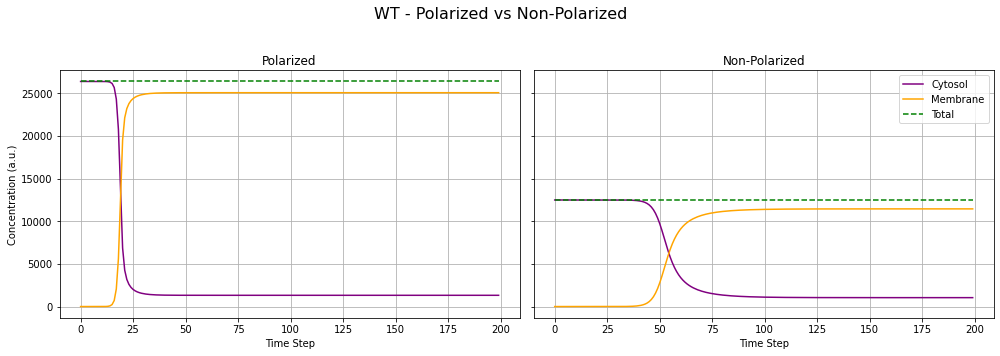

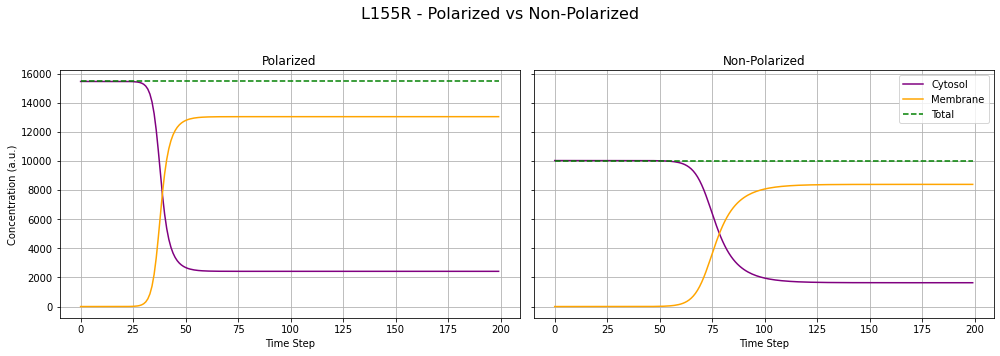

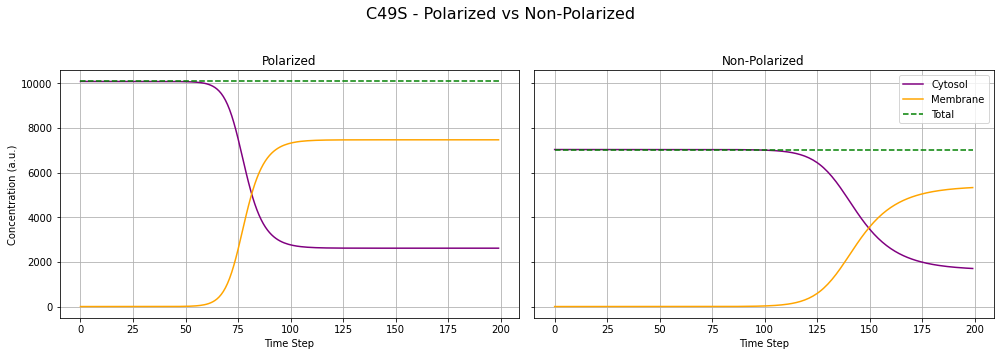

In [36]:
#Cytosol and membrane concentration
# Time setup
t = 200
dt = 0.000001

# Define the average cytosol concentration, membrane concentration and rate constants per genotype and per state
types = {
    "WT":    {"pol": { "avg_C": 1350.0671, "avg_M": 25044.6675,"K_on": 0.001177, "K_off": 0.001056, "K_coop": 0.001447, "K_diss": 0.000004        },
              "nonpol": {"avg_C": 1031.4577, "avg_M": 11463.9924,"K_on": 0.001175, "K_off": 0.001056, "K_coop": 0.001446, "K_diss": 0.000012}},
    "L155R": {"pol": {"avg_C": 2410.8862, "avg_M": 13044.1204, "K_on": 0.001151, "K_off": 0.001064, "K_coop": 0.001454, "K_diss": 0.000050},
              "nonpol": {"avg_C": 1636.9962, "avg_M": 8386.4974,"K_on": 0.001143, "K_off": 0.001080, "K_coop": 0.001447, "K_diss": 0.000055}},
    "C49S":  {"pol": {"avg_C": 2616.1362, "avg_M": 7466.1327,"K_on": 0.001145, "K_off": 0.001069, "K_coop": 0.001371, "K_diss": 0.000168        },
              "nonpol": {"avg_C": 1636.5114, "avg_M": 5396.3739,"K_on": 0.001141, "K_off": 0.001076, "K_coop": 0.001408, "K_diss": 0.000129}}
}

# Loop over each genotype
for cell_type in types:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    fig.suptitle(f"{cell_type} - Polarized vs Non-Polarized", fontsize=16)

    # Loop over each state (polarized and non-polarized)
    for idx, state in enumerate(["pol", "nonpol"]):
        data = types[cell_type][state]
        avg_C = data["avg_C"]
        avg_M = data["avg_M"]
        K_on = data["K_on"]
        K_off = data["K_off"]
        K_coop = data["K_coop"]
        K_diss = data["K_diss"]

        total_conc = avg_C + avg_M
        max_conc = total_conc

        
        C = [0] * t
        M = [0] * t
        # Define the inital state (average concentration)
        C[0] = total_conc
        M[0] = 0

        # Time evolution loop
        for i in range(1, t):
            dC = (-K_on * C[i-1] + K_off * M[i-1]
                  - 2 * K_coop * (C[i-1]**2) * M[i-1]
                  + 2 * K_diss * (M[i-1]**3)) * dt
            C[i] = C[i-1] + dC
            M[i] = total_conc - C[i]

            C[i] = min(max(C[i], 0), max_conc)
            M[i] = min(max(M[i], 0), max_conc)

        # Plotting the results for each cell type and each state
        ax = axes[idx]
        ax.plot(range(t), C, label="Cytosol", color="Purple")
        ax.plot(range(t), M, label="Membrane", color="Orange")
        ax.plot(range(t), [C[i] + M[i] for i in range(t)], label="Total", linestyle='--', color="green")
        ax.set_title("Polarized" if state == "pol" else "Non-Polarized")
        ax.set_xlabel("Time Step")
        if idx == 0:
            ax.set_ylabel("Concentration (a.u.)")
        
        ax.grid(True)
    plt.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


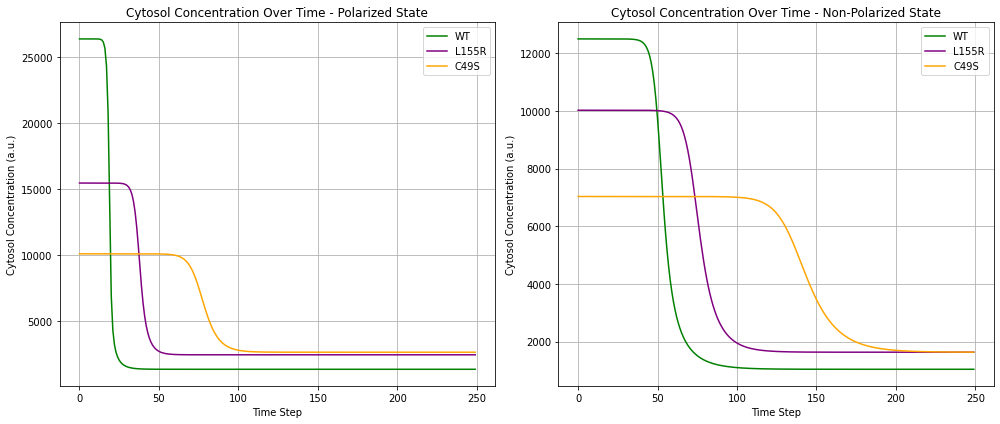

In [37]:
#Cytosol Concentration
# Time setup
t = 250
dt = 0.000001

# Define all values per type and per state using the provided data
types =  {
    "WT":    {"pol": { "avg_C": 1350.0671, "avg_M": 25044.6675,"K_on": 0.001177, "K_off": 0.001056, "K_coop": 0.001447, "K_diss": 0.000004        },
              "nonpol": {"avg_C": 1031.4577, "avg_M": 11463.9924,"K_on": 0.001175, "K_off": 0.001056, "K_coop": 0.001446, "K_diss": 0.000012}},
    "L155R": {"pol": {"avg_C": 2410.8862, "avg_M": 13044.1204, "K_on": 0.001151, "K_off": 0.001064, "K_coop": 0.001454, "K_diss": 0.000050},
              "nonpol": {"avg_C": 1636.9962, "avg_M": 8386.4974,"K_on": 0.001143, "K_off": 0.001080, "K_coop": 0.001447, "K_diss": 0.000055}},
    "C49S":  {"pol": {"avg_C": 2616.1362, "avg_M": 7466.1327,"K_on": 0.001145, "K_off": 0.001069, "K_coop": 0.001371, "K_diss": 0.000168        },
              "nonpol": {"avg_C": 1636.5114, "avg_M": 5396.3739,"K_on": 0.001141, "K_off": 0.001076, "K_coop": 0.001408, "K_diss": 0.000129}}
}


# Custom color palette
custom_palette = {
    "WT": "green",    # Green
    "L155R": "purple",  # Purple
    "C49S": "orange"     # Orange
}

# Create a single figure with 2 subplots (side by side)
fig, (ax_pol, ax_nonpol) = plt.subplots(1, 2, figsize=(14, 6))

# Loop over each genotype
for cell_type in types:
     for state, ax in zip(["pol", "nonpol"], [ax_pol, ax_nonpol]):
        data = types[cell_type][state]
        avg_C = data["avg_C"]
        avg_M = data["avg_M"]
        K_on = data["K_on"]
        K_off = data["K_off"]
        K_coop = data["K_coop"]
        K_diss = data["K_diss"]

        total_conc = avg_C + avg_M
        max_conc = total_conc

        C = [0] * t
        M = [0] * t
        # Define the inital state (average concentration)
        C[0] = total_conc
        M[0] = 0

        # Time evolution loop
        for i in range(1, t):
            dC = (-K_on * C[i-1] + K_off * M[i-1]
                  - 2 * K_coop * (C[i-1]**2) * M[i-1]
                  + 2 * K_diss * (M[i-1]**3)) * dt
            C[i] = C[i-1] + dC
            M[i] = total_conc - C[i]

            C[i] = min(max(C[i], 0), max_conc)
            M[i] = min(max(M[i], 0), max_conc)

        # Plot cytosol concentration over time
        ax.plot(range(t), C, label=cell_type, color=custom_palette[cell_type])

# plot the polarized state
ax_pol.set_title("Cytosol Concentration Over Time - Polarized State")
ax_pol.set_xlabel("Time Step")
ax_pol.set_ylabel("Cytosol Concentration (a.u.)")
ax_pol.legend()
ax_pol.grid(True)

# plot the non-polarized state
ax_nonpol.set_title("Cytosol Concentration Over Time - Non-Polarized State")
ax_nonpol.set_xlabel("Time Step")
ax_nonpol.set_ylabel("Cytosol Concentration (a.u.)")
ax_nonpol.legend()
ax_nonpol.grid(True)

# Show both plots 
plt.tight_layout()
plt.show()


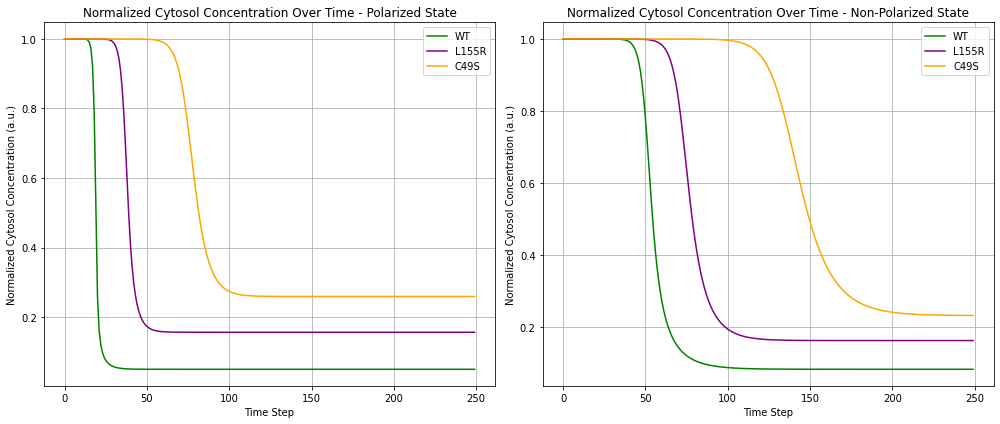

In [38]:
#Normalized cytosol concentration
# Time setup
t = 250
dt = 0.000001

# Define all values per type and per state using the provided data
types =  {
    "WT":    {"pol": { "avg_C": 1350.0671, "avg_M": 25044.6675,"K_on": 0.001177, "K_off": 0.001056, "K_coop": 0.001447, "K_diss": 0.000004        },
              "nonpol": {"avg_C": 1031.4577, "avg_M": 11463.9924,"K_on": 0.001175, "K_off": 0.001056, "K_coop": 0.001446, "K_diss": 0.000012}},
    "L155R": {"pol": {"avg_C": 2410.8862, "avg_M": 13044.1204, "K_on": 0.001151, "K_off": 0.001064, "K_coop": 0.001454, "K_diss": 0.000050},
              "nonpol": {"avg_C": 1636.9962, "avg_M": 8386.4974,"K_on": 0.001143, "K_off": 0.001080, "K_coop": 0.001447, "K_diss": 0.000055}},
    "C49S":  {"pol": {"avg_C": 2616.1362, "avg_M": 7466.1327,"K_on": 0.001145, "K_off": 0.001069, "K_coop": 0.001371, "K_diss": 0.000168        },
              "nonpol": {"avg_C": 1636.5114, "avg_M": 5396.3739,"K_on": 0.001141, "K_off": 0.001076, "K_coop": 0.001408, "K_diss": 0.000129}}
}


# Custom color palette
custom_palette = {
    "WT": "green",    # Green
    "L155R": "purple",  # Purple
    "C49S": "orange"     # Orange
}

# Create a single figure with 2 subplots (side by side)
fig, (ax_pol, ax_nonpol) = plt.subplots(1, 2, figsize=(14, 6))

# Loop over each genotype
for cell_type in types:
     for state, ax in zip(["pol", "nonpol"], [ax_pol, ax_nonpol]):
        data = types[cell_type][state]
        avg_C = data["avg_C"]
        avg_M = data["avg_M"]
        K_on = data["K_on"]
        K_off = data["K_off"]
        K_coop = data["K_coop"]
        K_diss = data["K_diss"]

        total_conc = avg_C + avg_M
        max_conc = total_conc
        
        C = [0] * t
        M = [0] * t
        # Define the inital state (average concentration)
        C[0] = total_conc
        M[0] = 0

        # Time evolution loop
        for i in range(1, t):
            dC = (-K_on * C[i-1] + K_off * M[i-1]
                  - 2 * K_coop * (C[i-1]**2) * M[i-1]
                  + 2 * K_diss * (M[i-1]**3)) * dt
            C[i] = C[i-1] + dC
            M[i] = total_conc - C[i]

            C[i] = min(max(C[i], 0), max_conc)
            M[i] = min(max(M[i], 0), max_conc)
            
        # Normalize the cytosol concentration by dividing by the maximum value
        max_C = max(C)
        if max_C > 0:
            C_normalized = [c / max_C for c in C]
        # If the max concentration is zero, just keep that concentration
        else:
            C_normalized = C  

        # Plot cytosol concentration (C) over time
        ax.plot(range(t), C_normalized, label=cell_type, color=custom_palette[cell_type])

# plot the polarized state
ax_pol.set_title("Normalized Cytosol Concentration Over Time - Polarized State")
ax_pol.set_xlabel("Time Step")
ax_pol.set_ylabel("Normalized Cytosol Concentration (a.u.)")
ax_pol.legend()
ax_pol.grid(True)

# plot the non-polarized state
ax_nonpol.set_title("Normalized Cytosol Concentration Over Time - Non-Polarized State")
ax_nonpol.set_xlabel("Time Step")
ax_nonpol.set_ylabel("Normalized Cytosol Concentration (a.u.)")
ax_nonpol.legend()
ax_nonpol.grid(True)

# Show both plots 
plt.tight_layout()
plt.show()
